## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
from urllib.parse import urlparse
from scipy.stats import spearmanr

from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from tqdm import tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset3, TextDataset4
from bert import CustomBert2, CustomBert3, CustomBert4
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

Using TensorFlow backend.


## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
# train = clean_data(train, INPUTS)
# test = clean_data(test, INPUTS)

In [4]:
train['question'] = train['question_title'] + ' \n \n \n ' + train['question_body']
test['question'] = test['question_title'] + ' \n \n \n ' + test['question_body']

In [5]:
init_seed()

In [6]:
%%time
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    ids, seg_ids = [], []
    for x in tqdm(df[['question', 'answer']].values):
        encoded_inputs = tokenizer.encode_plus(
            x[0], x[1], max_length=max_seq_len, pad_to_max_length=True, return_token_type_ids=True)
        ids.append(encoded_inputs['input_ids'])
        seg_ids.append(encoded_inputs['token_type_ids'])
    if mode == 'train': 
        ids_train = np.array(ids)
        seg_ids_train = np.array(seg_ids)
    else: 
        ids_test = np.array(ids)
        seg_ids_test = np.array(seg_ids)

100%|██████████| 476/476 [00:02<00:00, 207.37it/s]

CPU times: user 31.2 s, sys: 235 ms, total: 31.5 s
Wall time: 31.7 s


In [7]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [8]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)

cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [9]:
y = train[TARGETS].values.astype(np.float32)

In [10]:
num_workers = 10
bs = 4

In [11]:
bs_test = 4
test_loader = DataLoader(
    TextDataset4(cat_features_test, ids_test, seg_ids_test, test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers
)

## Training model

In [12]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 2
weight_decay = 0.01
model_name = 'bert_1'
checkpoint_dir = 'checkpoints/'
early_stopping = None

In [13]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    #return optim.Adam([#params=model.parameters(), lr=lr)#[
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 100, weight_decay)
    )

Fold 1 started at Sun Dec 15 18:15:15 2019


  0%|          | 0/200 [00:00<?, ?it/s]/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
 73%|███████▎  | 146/200 [00:27<00:10,  5.28it/s]

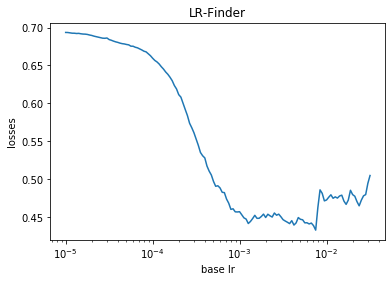

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42789 - spearmanr 0.18885
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.39024 - spearmanr 0.32907
best model: epoch 0 - 0.32907
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.38059 - spearmanr 0.32303
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.38586 - spearmanr 0.35725
best model: epoch 1 - 0.35725
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.36178 - spearmanr 0.3921
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.37165 - spearmanr 0.38476
best model: epoch 2 - 0.38476
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34167 - spearmanr 0.46149
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.37231 - spearmanr 0.38829
best model: epoch 3 - 0.38829
TRAINING END: Best score achieved on epoch 3 - 0.38829
Starting inference for model: checkpoints/bert_1_fold_1_best.pth



Starting inference for model: checkpoints/bert_1_fold_1_best.pth



Fold 2 started at Sun Dec 15 18:33:49 2019
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42709 - spearmanr 0.19257
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38991 - spearmanr 0.30827
best model: epoch 0 - 0.30827
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.38178 - spearmanr 0.31999
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37435 - spearmanr 0.36159
best model: epoch 1 - 0.36159
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.36197 - spearmanr 0.39637
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36753 - spearmanr 0.38825
best model: epoch 2 - 0.38825
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34261 - spearmanr 0.46107
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36566 - spearmanr 0.39628
best model: epoch 3 - 0.39628
TRAINING END: Best score achieved on epoch 3 - 0.39628
Starting inference for model: checkpoints/bert_1_fold_2_best.pth



Starting inference for model: checkpoints/bert_1_fold_2_best.pth



Fold 3 started at Sun Dec 15 18:51:38 2019
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42792 - spearmanr 0.18503
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38914 - spearmanr 0.31731
best model: epoch 0 - 0.31731
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.3815 - spearmanr 0.32204
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37301 - spearmanr 0.36999
best model: epoch 1 - 0.36999
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.36157 - spearmanr 0.39277
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36939 - spearmanr 0.38926
best model: epoch 2 - 0.38926
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34225 - spearmanr 0.45825
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36817 - spearmanr 0.3973
best model: epoch 3 - 0.3973
TRAINING END: Best score achieved on epoch 3 - 0.39730
Starting inference for model: checkpoints/bert_1_fold_3_best.pth



Starting inference for model: checkpoints/bert_1_fold_3_best.pth



Fold 4 started at Sun Dec 15 19:09:33 2019
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42821 - spearmanr 0.18563
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38984 - spearmanr 0.32044
best model: epoch 0 - 0.32044
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.38171 - spearmanr 0.32225
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37321 - spearmanr 0.36531
best model: epoch 1 - 0.36531
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.36212 - spearmanr 0.39393
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36945 - spearmanr 0.38846
best model: epoch 2 - 0.38846
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34269 - spearmanr 0.46051
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36726 - spearmanr 0.39471
best model: epoch 3 - 0.39471
TRAINING END: Best score achieved on epoch 3 - 0.39471
Starting inference for model: checkpoints/bert_1_fold_4_best.pth



Starting inference for model: checkpoints/bert_1_fold_4_best.pth



Fold 5 started at Sun Dec 15 19:27:24 2019
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.4252 - spearmanr 0.19703
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38819 - spearmanr 0.31509


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.31509
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.38041 - spearmanr 0.32781
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37745 - spearmanr 0.35465
best model: epoch 1 - 0.35465
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.36073 - spearmanr 0.39937
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36882 - spearmanr 0.38424
best model: epoch 2 - 0.38424
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34153 - spearmanr 0.46308
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36905 - spearmanr 0.39129
best model: epoch 3 - 0.39129
TRAINING END: Best score achieved on epoch 3 - 0.39129
Starting inference for model: checkpoints/bert_1_fold_5_best.pth



Starting inference for model: checkpoints/bert_1_fold_5_best.pth



OOF score: 0.3935518122716451


In [14]:
folds = KFold(n_splits=5, random_state=42)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds.split(train)):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset4(cat_features_train, ids_train, seg_ids_train, train_index, y),
        batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        TextDataset4(cat_features_train, ids_train, seg_ids_train, valid_index, y),
        batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True
    )
        
    model = CustomBert4(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=2)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / folds.n_splits
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.4027#0.4119

In [15]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [16]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.947787,0.706630,0.170590,0.517364,0.709669,0.646374,0.674911,0.621321,0.666703,0.000717,0.657261,0.721011,0.011144,0.187335,0.004380,0.003321,0.064410,0.083705,0.849654,0.000455,0.934873,0.893836,0.554190,0.952978,0.950043,0.801094,0.052932,0.056753,0.869480,0.904289
1,46,0.875531,0.507975,0.001838,0.788110,0.785181,0.955323,0.555194,0.451298,0.093794,0.001906,0.416271,0.621815,0.000874,0.000474,0.000462,0.003091,0.891344,0.172209,0.080223,0.000126,0.715664,0.950075,0.650334,0.974167,0.979791,0.879113,0.874263,0.121264,0.149825,0.897776
2,70,0.922137,0.730088,0.013812,0.812333,0.911549,0.954949,0.608473,0.489252,0.219994,0.001036,0.213350,0.881570,0.007987,0.041811,0.001700,0.004472,0.081177,0.053817,0.618147,0.000471,0.896052,0.923834,0.610223,0.960170,0.968072,0.862527,0.087406,0.057954,0.807878,0.906876
3,132,0.889508,0.503404,0.004531,0.734711,0.791119,0.920998,0.540624,0.425802,0.086989,0.007832,0.432417,0.030825,0.001164,0.002220,0.000585,0.003376,0.841268,0.215869,0.516949,0.000230,0.740322,0.961105,0.690434,0.978432,0.987454,0.910432,0.821741,0.195318,0.741738,0.906775
4,200,0.910851,0.367569,0.030535,0.845320,0.718068,0.841257,0.653790,0.630831,0.106039,0.021674,0.487181,0.262685,0.007560,0.017600,0.003227,0.020339,0.220600,0.115504,0.620369,0.001047,0.652369,0.920315,0.650334,0.966914,0.964381,0.846559,0.200204,0.110216,0.800817,0.909311


In [17]:
segs = torch.tensor(seg_ids_test)
ids = torch.tensor(ids_test).unsqueeze(-1).repeat(1,1,7)

In [18]:
(ids*(segs==0).unsqueeze(-1)).sum(1).size()

torch.Size([476, 7])